In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Reading in the data

In [2]:
df = pd.read_csv('bank-full.csv', sep=';')
df.head()

,"age;""job"";""marital"";""education"";""default"";""balance"";""housing"";""loan"";""contact"";""day"";""month"";""duration"";""campaign"";""pdays"";""previous"";""poutcome"";""y"""
0,"58;""management"";""married"";""tertiary"";""no"";2143..."
1,"44;""technician"";""single"";""secondary"";""no"";29;""..."
2,"33;""entrepreneur"";""married"";""secondary"";""no"";2..."
3,"47;""blue-collar"";""married"";""unknown"";""no"";1506..."
4,"33;""unknown"";""single"";""unknown"";""no"";1;""no"";""n..."


In [3]:
df.shape[0]

45211

Appears the data won't read nicely, the dataset is only 45 thousand rows so not very big. Seems as though its the quotation marks that are causing the reading issue. To solve I will use string manipulation on each row.

In [4]:
import csv

# create a list to store the rows in
store = []

with open('bank-full.csv', 'r') as file:
    # delimeter isn't working, assume because of the ""
    reader = csv.reader(file)
    for i, row in enumerate(reader):
        # get the headings
        if i == 0:
            columns = row[0].replace('"', '').split(';')
        else:
            store.append(row[0].replace('"', '').split(';'))

# place values in a dataframe
df = pd.DataFrame(store, columns=columns)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  object
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  object
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  object
 10  month      45211 non-null  object
 11  duration   45211 non-null  object
 12  campaign   45211 non-null  object
 13  pdays      45211 non-null  object
 14  previous   45211 non-null  object
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: object(17)
memory usage: 5.9+ MB


All currently stored as a string. The numeric values will be converted based on observations from the df.head(), and a list of both the categorical columns and the numeric columns will be saved for later use.

### Check for unknowns and missing values

Appears unknown is a na value in the dataframe. 

In [6]:
# inspect for missinbg values
df[df == 'unknown'] = np.nan
# return percentage of column that is missing
round(df.isna().sum()/df.shape[0]*100,1)

age           0.0
job           0.6
marital       0.0
education     4.1
default       0.0
balance       0.0
housing       0.0
loan          0.0
contact      28.8
day           0.0
month         0.0
duration      0.0
campaign      0.0
pdays         0.0
previous      0.0
poutcome     81.7
y             0.0
dtype: float64

Inital thoughts are to discard poutcome column as mostly missing, may drop  education and job to drop rows as less than 5% total.

In [7]:
df['contact'].fillna('Not provided', inplace=True)
(pd.crosstab(df['y'], df['contact'],margins=True)*1).style.background_gradient(cmap='coolwarm')

contact,Not provided,cellular,telephone,All
y,,,,
no,12490,24916,2516,39922
yes,530,4369,390,5289
All,13020,29285,2906,45211


Seems most people who do not provide telephone contacts result in a no, so it is likely significant and values will be retained as 'Not provided'.

Handle other missing values below.

In [8]:
# Drop column mostly missing values
df.drop(columns=['poutcome'], inplace=True)
# Drop rows as combined less than 5% of the data
df.dropna(axis=0, inplace=True)

In [9]:
df.shape

(43193, 16)

## Inspect the target Varible

In [10]:
from collections import Counter
# Count the number of goods vs bads
Counter(df['y'])

Counter({'no': 38172, 'yes': 5021})

A imbalanced target varible can lead to poor classification, two solutions include using under and oversampling.

In [11]:
success_ratio = round(100*Counter(df['y'])['yes']/(Counter(df['y'])['yes']+Counter(df['y'])['no']),1)
print('The ratio of success is', success_ratio, '%')

The ratio of success is 11.6 %


The success ratio suggests that the current technique of marketing only results in 11.7% successful output, therefore this will act as my benchmark, to iterate upon and improve the success ratio.

In [12]:
df['y'].unique()

array(['no', 'yes'], dtype=object)

# What type of Customer
Look at a few of their categorical characteristics to determine, what kind of customer is most receptive to the campaign.
## Hists

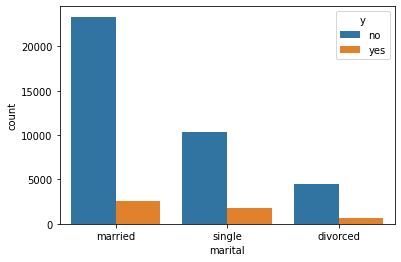

In [13]:
sns.countplot(x='marital',hue='y',data=df)
plt.show()

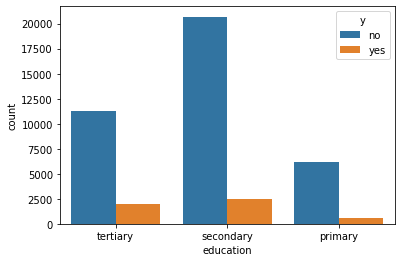

In [14]:
sns.countplot(x='education',hue='y',data=df)
plt.show()

## Crosstabs

In [15]:
(pd.crosstab(df['y'], df['marital'],margins=True,normalize='columns')*100).style.background_gradient(cmap='coolwarm')

marital,divorced,married,single,All
y,,,,
no,88.106603,89.967625,85.105164,88.375431
yes,11.893397,10.032375,14.894836,11.624569


In [16]:
(pd.crosstab(df['y'],df['education'],margins=True,normalize='columns')*100).style.background_gradient(cmap='coolwarm')

education,primary,secondary,tertiary,All
y,,,,
no,91.352941,89.447062,84.979641,88.375431
yes,8.647059,10.552938,15.020359,11.624569


It would appear that customers who are single and have a tertiary eucation are most receptive to the advertising campagin.

In [17]:
df_selective = df.loc[(df['marital']=='single') & (df['education']=='tertiary')]

In [18]:
(pd.crosstab(df_selective['y'], df_selective['job'],margins=True,normalize='columns')*100).style.background_gradient(cmap='coolwarm')

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,All
y,,,,,,,,,,,,
no,81.884058,76.470588,91.911765,75.609756,82.546440,77.777778,75.570033,83.505155,71.717172,83.593750,73.880597,81.656557
yes,18.115942,23.529412,8.088235,24.390244,17.453560,22.222222,24.429967,16.494845,28.282828,16.406250,26.119403,18.343443


The results suggest the best candidates to target with marketing are highly educated, single and student. However, if they also work in one of the following professions: student, unemployed, self-employed, housemaid, blue collar or retired, the rate of positive response will be in excess of 22% almost double the average rate of success across all customers. In fact for all highly educated single people that are not entrepeneurs, targetting them for the advertising campaign would be more successful than the 11.7% achieved previously.
# Statistics

### Binary Variables
Test to see if has housing loan yes vs housing loan no has a statistical significance on the average outcome of marketing.
- Null hypothesis H0: No difference in average result
- Alternative hypothesis H1: difference in average result

In [19]:
from scipy import stats
statistics = df.copy()
statistics['y'] = pd.get_dummies(statistics['y'], drop_first=True)
# set up the test for housing
var1 = statistics['y'].loc[statistics['housing']=='yes'].values
var2 = statistics['y'].loc[statistics['housing']=='no'].values
print('mean:',round(var1.mean(),3),'var:', round(var1.var(),3))
print('mean:',round(var2.mean(),3),'var:', round(var2.var(),3))
print('levene:', stats.levene(var1,var2).pvalue)
print('ttest:',stats.ttest_ind(var1,var2, equal_var=False).pvalue)

mean: 0.077 var: 0.071
mean: 0.166 var: 0.139
levene: 2.0778342739892737e-183
ttest: 4.6155621951161294e-169


The p-values suggest a significant difference in the average result to a confidence of $\alpha$ = 0.001.

Test to see if default yes vs default no has a statistical significance on the average outcome of marketing. 
- Null hypothesis H0:  No difference in average result 
- Alternative hypothesis H1: difference in average result

In [20]:
# set up the test for default
var1 = statistics['y'].loc[statistics['default']=='yes'].values
var2 = statistics['y'].loc[statistics['default']=='no'].values
print('mean:',round(var1.mean(),3),'var:', round(var1.var(),3))
print('mean:',round(var2.mean(),3),'var:', round(var2.var(),3))
print('levene:', stats.levene(var1,var2).pvalue)
print('ttest:',stats.ttest_ind(var1,var2, equal_var=False).pvalue)

mean: 0.061 var: 0.058
mean: 0.117 var: 0.104
levene: 1.3571245145269905e-06
ttest: 2.579998745852084e-10


The p-values suggest a significant difference in the average result to a confidence of  𝛼  = 0.001.

Test to see if loan yes vs loan no has a statistical significance on the average outcome of marketing.

- Null hypothesis H0: No difference in average result
- Alternative hypothesis H1: difference in average result

In [21]:
# set up the test for loan
var1 = statistics['y'].loc[statistics['loan']=='yes'].values
var2 = statistics['y'].loc[statistics['loan']=='no'].values
print('mean:',round(var1.mean(),3),'var:', round(var1.var(),3))
print('mean:',round(var2.mean(),3),'var:', round(var2.var(),3))
print('levene:', stats.levene(var1,var2).pvalue)
print('ttest:',stats.ttest_ind(var1,var2, equal_var=False).pvalue)

mean: 0.067 var: 0.062
mean: 0.126 var: 0.11
levene: 1.7468395118237252e-46
ttest: 1.9948003461297642e-66


The p-values suggest a significant difference in the average result to a confidence of  𝛼  = 0.001.

It would seem that all the binary varibles default, loan and housing are statistically significant, whilst the variance has not been checked to be equal at this significance level it is unessecary, also the sample sizes are sufficently large and should obey central limit theorem.
### Marital

Test to see if married customers vs single and divorced customers average response is statistical significant to the average outcome of marketing.

Null hypothesis H0: No difference in average result
Alternative hypothesis H1: difference in average result

In [22]:
# set up the test for default
var1 = statistics['y'].loc[(statistics['marital']=='single') | (statistics['marital']=='divorced')].values
var2 = statistics['y'].loc[statistics['marital']=='married'].values
print('mean:',round(var1.mean(),3),'var:', round(var1.var(),3))
print('mean:',round(var2.mean(),3),'var:', round(var2.var(),3))
print('levene:', stats.levene(var1,var2).pvalue)
print('ttest:',stats.ttest_ind(var1,var2, equal_var=False).pvalue)

mean: 0.14 var: 0.121
mean: 0.1 var: 0.09
levene: 8.22721400301318e-37
ttest: 8.009330223728477e-35


The p-values suggest a significant difference in the average result to a confidence of  𝛼  = 0.001.

## Education
Test to see if primary education vs secondary or greater has a statistical significance on the average outcome of marketing.

- Null hypothesis H0: No difference in average result
- Alternative hypothesis H1: difference in average result

In [23]:
# set up the test for default
var1 = statistics['y'].loc[(statistics['education']=='secondary') | (statistics['education']=='teritary')].values
var2 = statistics['y'].loc[statistics['education']=='primary'].values
print('mean:',round(var1.mean(),3),'var:', round(var1.var(),3))
print('mean:',round(var2.mean(),3),'var:', round(var2.var(),3))
print('levene:', stats.levene(var1,var2).pvalue)
print('ttest:',stats.ttest_ind(var1,var2, equal_var=False).pvalue)

mean: 0.106 var: 0.094
mean: 0.086 var: 0.079
levene: 4.612812160258219e-06
ttest: 1.526908659018407e-06


The p-values suggest a significant difference in the average result to a confidence of  𝛼  = 0.001.

# Define Data types

In [24]:
# create list of numeric columns based on readme
numeric_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
# convert to int - breif inspect showed that the data wasn't floats
df[numeric_columns] = df[numeric_columns].astype(int)
# extract the categorical columns
cat_columns = df.drop(columns=['y']).select_dtypes('object').columns
# target column
target = 'y'

# Handle Data
## Numeric
### Outliers

In [25]:
# nspect the numeric columns
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,43193.0,40.764082,10.512640,18.0,33.0,39.0,48.0,95.0
balance,43193.0,1354.027342,3042.103625,-8019.0,71.0,442.0,1412.0,102127.0
day,43193.0,15.809414,8.305970,1.0,8.0,16.0,21.0,31.0
duration,43193.0,258.323409,258.162006,0.0,103.0,180.0,318.0,4918.0
campaign,43193.0,2.758178,3.063987,1.0,1.0,2.0,3.0,58.0
pdays,43193.0,40.404070,100.420624,-1.0,-1.0,-1.0,-1.0,871.0
previous,43193.0,0.584863,2.332672,0.0,0.0,0.0,0.0,275.0


<AxesSubplot:xlabel='campaign'>

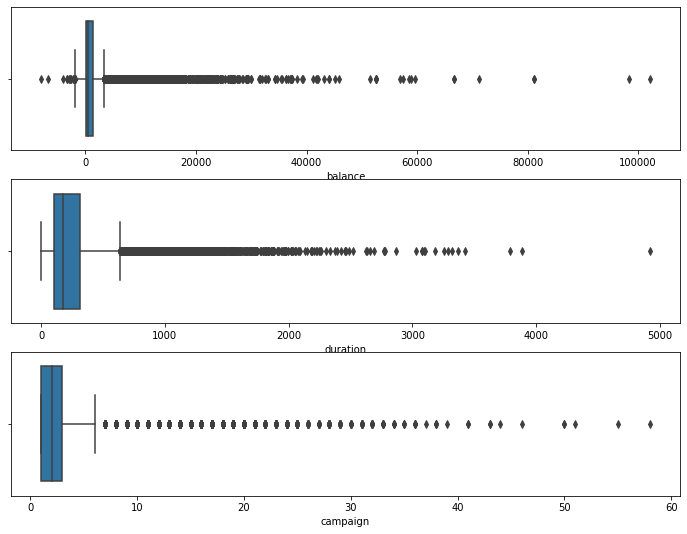

In [26]:
f, ax = plt.subplots(3, figsize=(12,9))
sns.boxplot(x=df['balance'], ax=ax[0], data=df)
sns.boxplot(x=df['duration'], ax=ax[1], data=df)
sns.boxplot(x=df['campaign'], ax=ax[2], data=df)

<AxesSubplot:xlabel='campaign'>

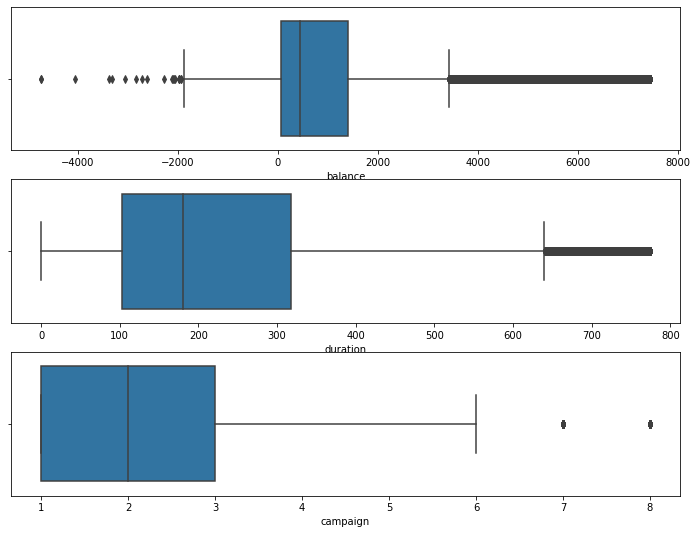

In [27]:
def remove_outliers(df, col, deviations=3, d_type='float'):
    '''This function removes outliers based on their Z-score,
    any value above or below 3 standard deviations from the 
    mean are replaced by this cutoff value.
    '''
    # decide if the results should be ints or floats
    if d_type == 'float':
        z_upper = df[col].mean() + deviations*df[col].std()
        z_lower = df[col].mean() - deviations*df[col].std()
    else:
        z_upper = int(df[col].mean() + deviations*df[col].std())
        z_lower = int(df[col].mean() - deviations*df[col].std())
    # replace values above and below    
    df.loc[df[col] > z_upper, col] = z_upper
    df.loc[df[col] < z_lower, col] = z_lower

# remove outliers  
for col in ['balance', 'duration', 'campaign', 'pdays', 'previous']:
    remove_outliers(df, col, 2, 'ints')

# plot new boxplots
f, ax = plt.subplots(3, figsize=(12,9))
sns.boxplot(x=df['balance'], ax=ax[0], data=df)
sns.boxplot(x=df['duration'], ax=ax[1], data=df)
sns.boxplot(x=df['campaign'], ax=ax[2], data=df)

In [28]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,43193.0,40.764082,10.512640,18.0,33.0,39.0,48.0,95.0
balance,43193.0,1161.011923,1805.304809,-4730.0,71.0,442.0,1412.0,7438.0
day,43193.0,15.809414,8.305970,1.0,8.0,16.0,21.0,31.0
duration,43193.0,242.551525,195.641764,0.0,103.0,180.0,318.0,774.0
campaign,43193.0,2.511240,1.901326,1.0,1.0,2.0,3.0,8.0
pdays,43193.0,32.875628,76.629555,-1.0,-1.0,-1.0,-1.0,241.0
previous,43193.0,0.464404,1.168792,0.0,0.0,0.0,0.0,5.0


## Encode
pd.dummies

In [29]:
# encode target varible
y = pd.get_dummies(df[target], drop_first=True)
# encode features
X = pd.get_dummies(df[cat_columns], drop_first=True)
# re-add numeric columns
X[numeric_columns] = df[numeric_columns]
X.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,month_nov,month_oct,month_sep,age,balance,day,duration,campaign,pdays,previous
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,58,2143,5,261,1,-1,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,44,29,5,151,1,-1,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,33,2,5,76,1,-1,0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,35,231,5,139,1,-1,0
6,0,0,0,1,0,0,0,0,0,0,...,0,0,0,28,447,5,217,1,-1,0


# Model

For the modelling, the target varible is inbalanced in the training data. The model was trained and compared for imbalanced data, over-sampled data using SMOTE and undersampled data. The results between imbalanced and oversampled are very similar, the undersampled data, however, is significantly more interesting as the precision of the model reduces by approximatley 0.2 but the recall significantly increases approx 0.36 to 0.9 and the F-score increases by 0.1.

In [30]:
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.model_selection import train_test_split

# split training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# undersampling
print('Original dataset shape %s' % Counter(y['yes']))
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_under['yes']))

Original dataset shape Counter({0: 38172, 1: 5021})
Resampled dataset shape Counter({0: 4040, 1: 4040})


In [31]:
from sklearn.ensemble import RandomForestClassifier
clf_under = RandomForestClassifier(n_estimators = 200, min_samples_leaf=1, random_state=42)
clf_under.fit(X_train_under, y_train_under.values.flatten())
preds_under = clf_under.predict(X_test)

recall: 0.8980632008154944
precision: 0.4111059262715819
f1_score: 0.5640204865556979
accuracy: 0.8423428637573793


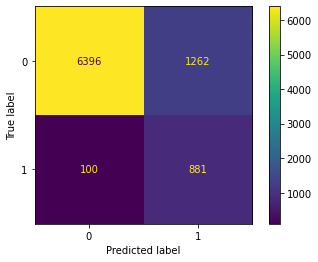

In [32]:
from sklearn.metrics import recall_score, precision_score, f1_score, plot_confusion_matrix, accuracy_score
print('recall:', recall_score(y_test, preds_under))
print('precision:', precision_score(y_test, preds_under))
print('f1_score:', f1_score(y_test, preds_under))
print('accuracy:', accuracy_score(y_test, preds_under))
plot_confusion_matrix(clf_under, X_test, y_test)

### Conclusion
So what does this model actually mean? The model will correctly identify 90% possible customers, at the same time 4 out of 10 customers contacted will take the product. By comparison the current marketing campagin strategy only 1 in 10 customers will take the product. This means the marketing costs can be reduced by as much as 75%, as less customers will need to be contacted to achieve the same results as the current marketing strategy.

(Note figures marginally rounded 12/100 for original, 41/100 for model).

## Features
The best 10 features shown below.

In [33]:
importances = clf_under.feature_importances_
columns = list(X.columns)
features, values = [], []
for _ in range(34):
    idx = np.where(importances == importances.max())[0][0]
    #print(columns[idx], 'importance:', round(importances[idx],3))
    features.append(columns[idx])
    values.append(round(importances[idx],3))
    importances = np.delete(importances,idx) 
    columns.remove(columns[idx])

features = pd.DataFrame({'Feature': features, 'Importance': values})
features.head(10)

,Feature,Importance
0,duration,0.345
1,balance,0.087
2,age,0.086
3,day,0.075
4,pdays,0.044
5,campaign,0.036
6,contact_cellular,0.031
7,housing_yes,0.031
8,previous,0.029
9,month_may,0.017
